In [7]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn.preprocessing import StandardScaler
import arviz as az
import preliz as pz

#test

settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5}
plt.rcParams.update(settings)

SEED = sum(map(ord, 'Forcasting in PyMC'))
rng = np.random.default_rng(SEED)

In [8]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

In [9]:
data = pd.read_csv("../data/a0_combinedQuarterly_new.csv", index_col=[0])
data = data['gdp_total_season'].to_frame()

scaler = StandardScaler()
data = scaler.fit_transform(data)

T = data.shape[0]
t = np.arange(T)

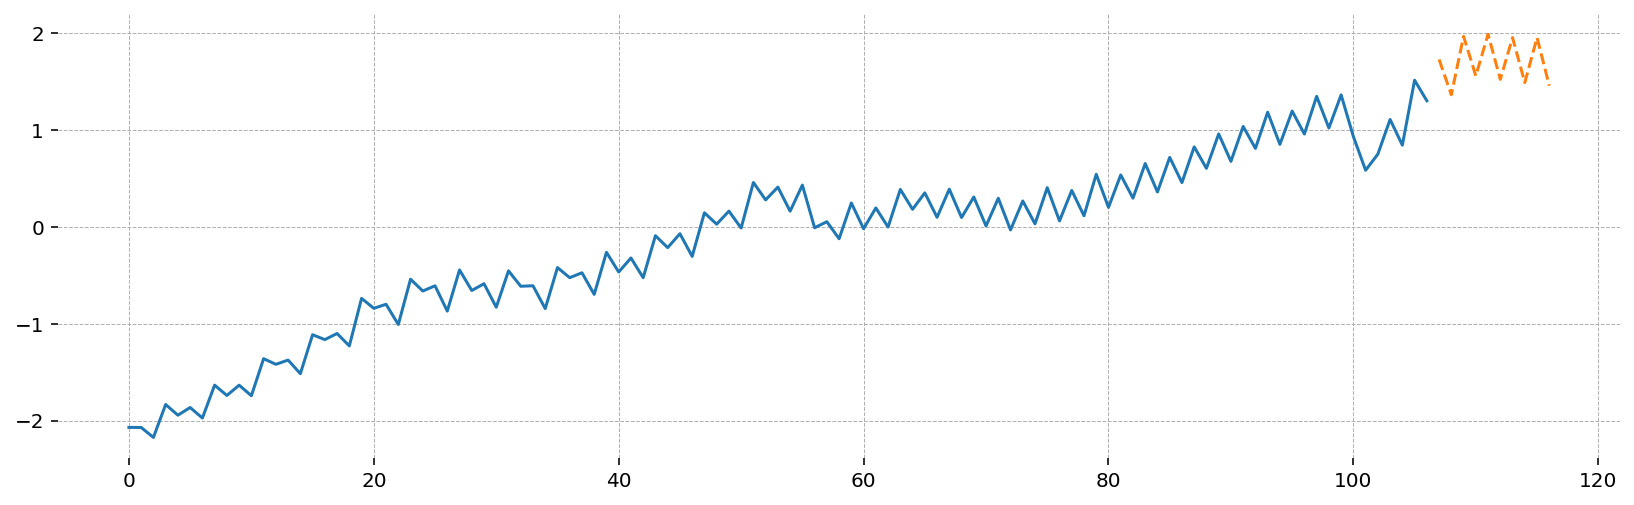

In [10]:
train_data = data[:107]
test_data = data[-10:]

plt.plot(train_data, color='tab:blue')
plt.plot(np.arange(107, 117), test_data, ls='--', color='tab:orange')

In [11]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.95, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [30]:
# A one-dimensional column vector of inputs.
x = np.arange(0, data.shape[0])
y = data
y = y.flatten()

In [31]:

X = x[:,None]
with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.InverseGamma("ℓ", **get_ig_params(x, l_b=1))
    
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfNormal('σ', 2)

    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, sigma=σ)
    idata_reg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [32]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

In [33]:
with model_reg:
    idata_reg_subset = idata_reg.sel(draw=slice(0, None, 100))
    pred_samples = pm.sample_posterior_predictive(idata_reg_subset,
                                                  var_names=["f_pred"],
                                                  random_seed=123)

f_pred = (pred_samples.
          posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
          values)

Sampling: [f_pred]


Output()

Text(0.5, 0, 'X')

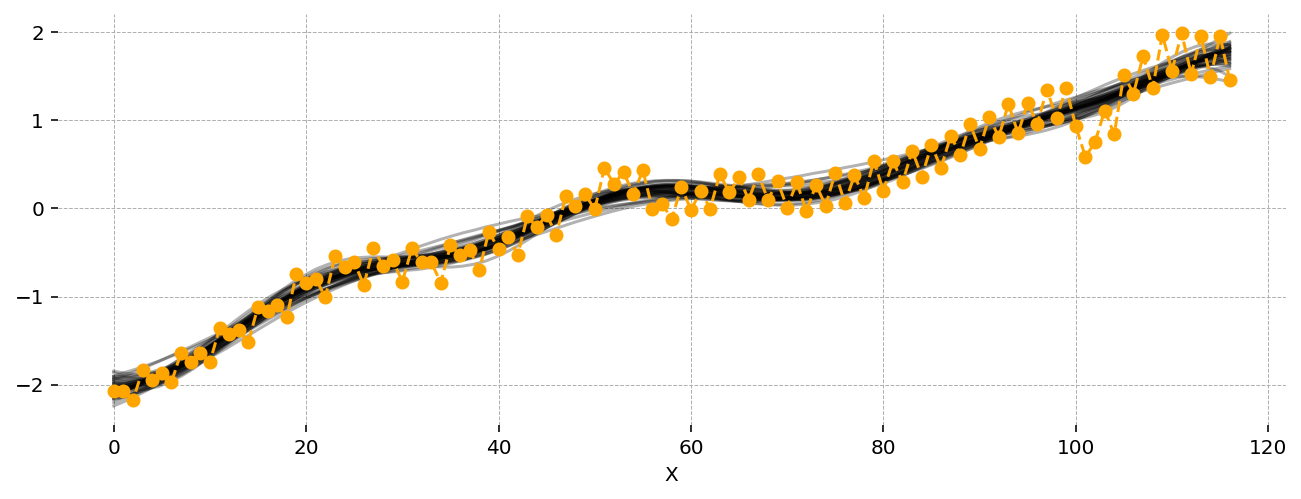

In [37]:
_, ax = plt.subplots(figsize=(11, 3.7))
ax.plot(X_new, f_pred, 'black', alpha=0.3)
ax.plot(X, y, color='orange', marker='o', linestyle='dashed');
ax.set_xlabel('X')

Text(0, 0.5, 'f(x)')

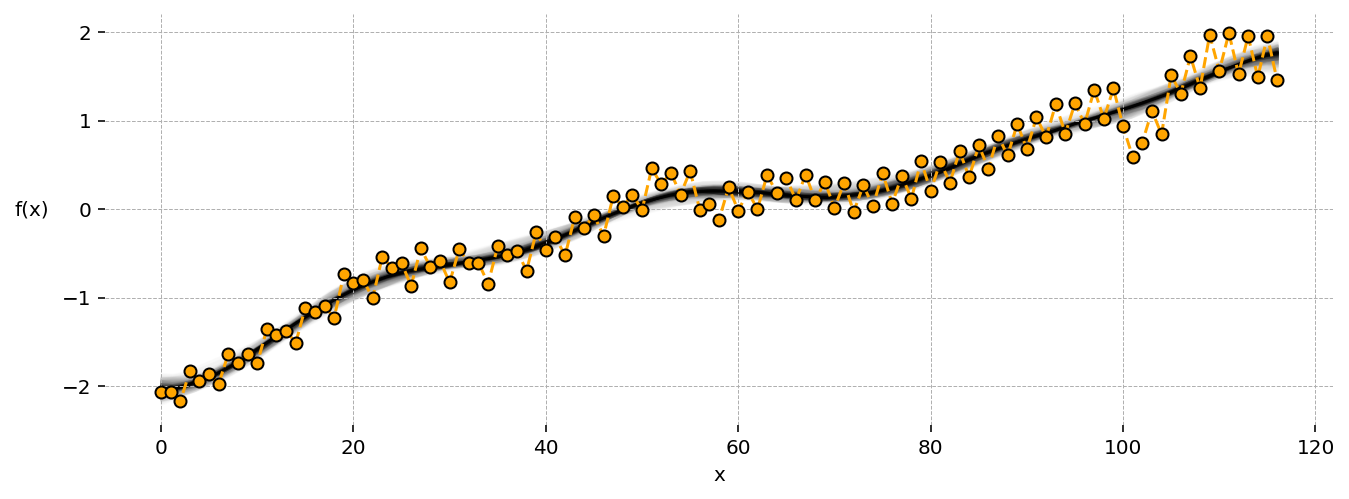

In [42]:
_, ax = plt.subplots(figsize=(11, 3.7))

pm.gp.util.plot_gp_dist(ax, f_pred.T, X_new, palette='gray_r', plot_samples=False);

ax.plot(X, y, mec='k', color="orange", marker='o', linestyle='dashed')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)


Text(0.5, 0, 'X')

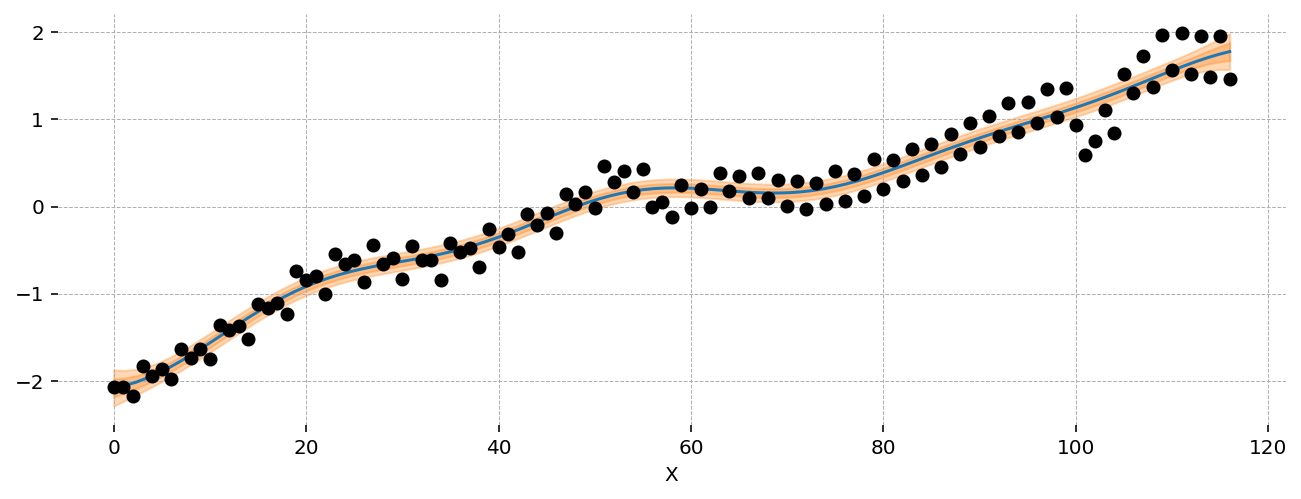

In [43]:
# plot the results
_, ax = plt.subplots(figsize=(11, 3.7))

# predict
point = {'ℓ': idata_reg.posterior['ℓ'].mean(), 'σ': idata_reg.posterior['σ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True,  model=model_reg)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C0')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')
##